In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime, timedelta

In [26]:
df = pd.read_csv("healthcare_dataset.csv")

In [ ]:
# Фільтрація для бінарної класифікації

df_binary = df[df['Test Results'].isin(['Normal', 'Abnormal'])].copy()

df_binary['y'] = (df_binary['Test Results'] == 'Normal').astype(int)

In [46]:
df_binary['Test Results'].unique()

array(['Normal', 'Abnormal'], dtype=object)

In [29]:
# Видалення непотрібних стовпців
drop_cols = ['Name', 'Date of Admission', 'Doctor', 'Hospital', 'Room Number', 'Discharge Date', 'Test Results']
X = df_binary.drop(drop_cols + ['y'], axis=1)
y = df_binary['y'].values

In [30]:
# One-hot encoding
categoricals = ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication']
X = pd.get_dummies(X, columns=categoricals, drop_first=True)
X = X.astype(float)  # Для сумісності типів


Розподіл y: y
0    0.501481
1    0.498519
Name: proportion, dtype: float64


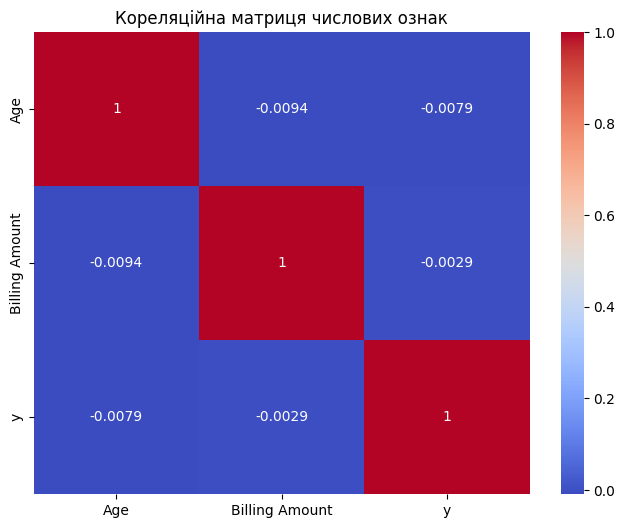

In [31]:
# EDA
print('Розподіл y:', df_binary['y'].value_counts(normalize=True))
numeric_cols = ['Age', 'Billing Amount']
corr_matrix = df_binary[numeric_cols + ['y']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Кореляційна матриця числових ознак')
plt.show()

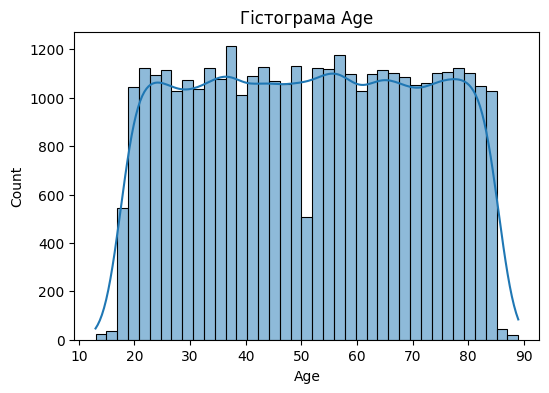

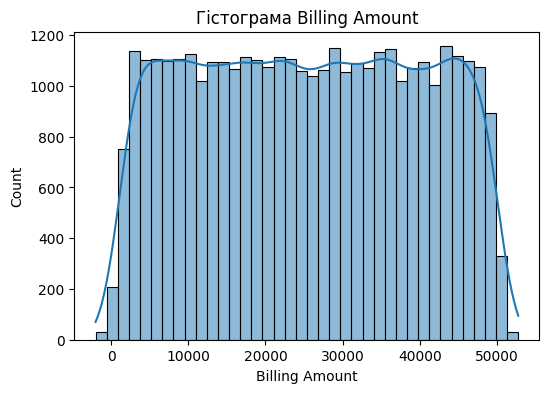

In [32]:
# Гістограми
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_binary[col], kde=True)
    plt.title(f'Гістограма {col}')
    plt.show()

In [33]:
# Розділ на train (60%), val (20%), test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [34]:
# Масштабування числових
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [35]:
# Додавання intercept
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_val = np.c_[np.ones(X_val.shape[0]), X_val]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

In [36]:
# 3. Реалізація логістичної регресії
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(X, y, w, lambda_=0):
    p = sigmoid(np.dot(X, w))
    m = len(y)
    log_loss = -np.mean(y * np.log(p + 1e-10) + (1 - y) * np.log(1 - p + 1e-10))
    reg = (lambda_ / (2 * m)) * np.sum(w[1:]**2)  # L2, без bias
    return log_loss + reg

def compute_gradient(X, y, w, lambda_=0):
    p = sigmoid(np.dot(X, w))
    m = len(y)
    grad = np.dot(X.T, (p - y)) / m
    grad[1:] += (lambda_ / m) * w[1:]  # L2, без bias
    return grad

In [37]:
# Функція для get_batches (для mini-batch)
def get_batches(X, y, batch_size):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    for start in range(0, len(y), batch_size):
        end = min(start + batch_size, len(y))
        yield X[indices[start:end]], y[indices[start:end]]

In [38]:
# Навчання з early stopping та learning curves
def train_logistic(X_train, y_train, X_val, y_val, learning_rate=0.1, max_epochs=50, batch_size=32, lambda_=0.01, patience=5):
    n_features = X_train.shape[1]
    w = np.zeros(n_features)
    best_val_loss = float('inf')
    best_epoch = 0
    best_w = None
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        if batch_size == 1:  # SGD
            for i in range(len(y_train)):
                grad = compute_gradient(X_train[i:i+1], y_train[i:i+1], w, lambda_)
                w -= learning_rate * grad
        else:  # Mini-batch
            for batch_X, batch_y in get_batches(X_train, y_train, batch_size):
                grad = compute_gradient(batch_X, batch_y, w, lambda_)
                w -= learning_rate * grad
        
        train_loss = compute_loss(X_train, y_train, w, lambda_)
        val_loss = compute_loss(X_val, y_val, w, lambda_)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_w = w.copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return best_w, train_losses, val_losses

In [39]:
# Навчання SGD (batch_size=6, без reg)
w_sgd, train_losses_sgd, val_losses_sgd = train_logistic(X_train, y_train, X_val, y_val, batch_size=1, lambda_=0.01)

# Навчання Mini-batch (batch_size=32, з L2)
w_mini, train_losses_mini, val_losses_mini = train_logistic(X_train, y_train, X_val, y_val, batch_size=32, lambda_=0.01)

Early stopping at epoch 6
Early stopping at epoch 11


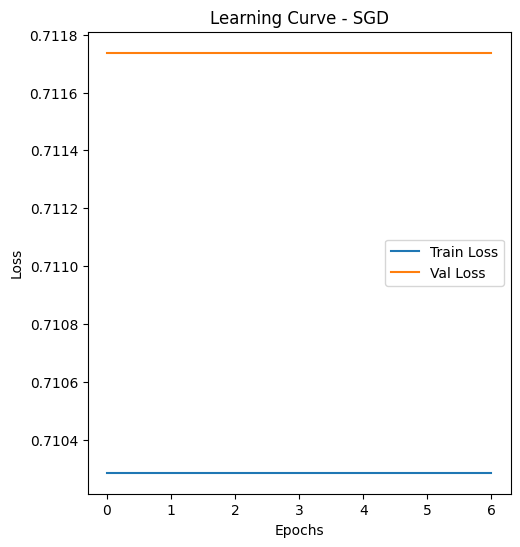

In [40]:
# Графіки learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses_sgd, label='Train Loss')
plt.plot(val_losses_sgd, label='Val Loss')
plt.title('Learning Curve - SGD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

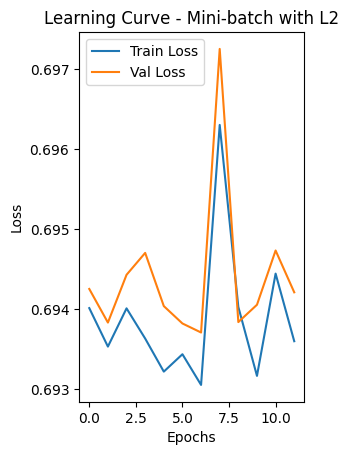

In [41]:
plt.subplot(1, 2, 2)
plt.plot(train_losses_mini, label='Train Loss')
plt.plot(val_losses_mini, label='Val Loss')
plt.title('Learning Curve - Mini-batch with L2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
# 6. Оцінка якості моделі
def evaluate(w, X_test, y_test):
    y_pred_prob = sigmoid(np.dot(X_test, w))
    y_pred = (y_pred_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return cm, acc, prec, rec, f1

In [43]:
cm_sgd, acc_sgd, prec_sgd, rec_sgd, f1_sgd = evaluate(w_sgd, X_test, y_test)
cm_mini, acc_mini, prec_mini, rec_mini, f1_mini = evaluate(w_mini, X_test, y_test)

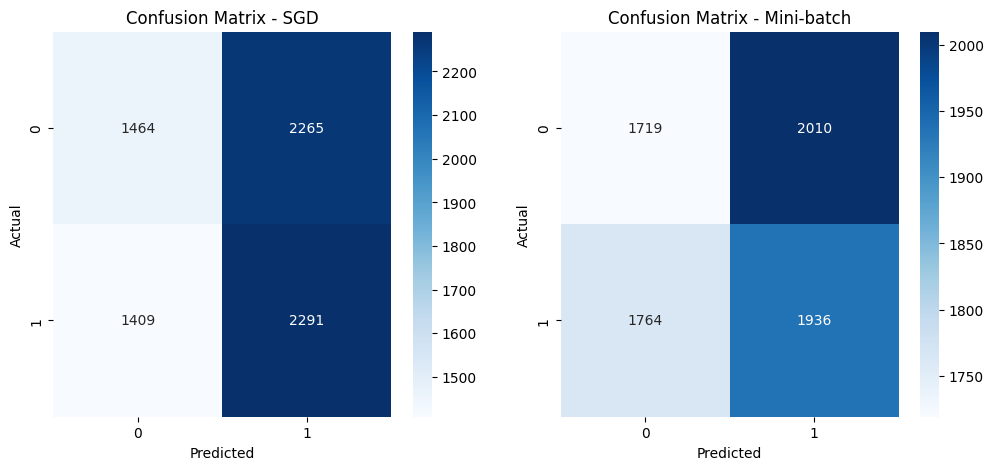

In [44]:
# Confusion matrix графіки
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SGD')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_mini, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Mini-batch')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [45]:
# Порівняльна таблиця
metrics_df = pd.DataFrame({
    'Method': ['SGD', 'Mini-batch L2'],
    'Accuracy': [acc_sgd, acc_mini],
    'Precision': [prec_sgd, prec_mini],
    'Recall': [rec_sgd, rec_mini],
    'F1-score': [f1_sgd, f1_mini]
})
print(metrics_df)

          Method  Accuracy  Precision    Recall  F1-score
0            SGD  0.505452   0.502853  0.619189  0.554990
1  Mini-batch L2  0.491991   0.490623  0.523243  0.506409
